# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


# HYper Parameter Tunning
This was one of the toughest part of this project for me, i tried using DDPG from the continous control assignment, for this project, however tunning the right hyper parameters took several trails. had to keep track of hyper parameters which I attached in the work document following this submission.
also it felt like the GPU did not make much of the difference for this project.

In [6]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import copy

In [7]:
BUFFER_SIZE = int(5e5)          # replay buffer size
BATCH_SIZE = 128                # minibatch size
GAMMA = 0.99                    # discount factor
TAU = 8e-3                      # for soft update of target parameters
LR_ACTOR = 1e-3                 # learning rate of the actor
LR_CRITIC = 1e-3                # learning rate of the critic
WEIGHT_DECAY = 0                # L2 weight decay
EPISODES = 10000                # max number of episodes


# DDPG Agent
DDPG uses an actor-critic architecture, where the actor network learns the policy, and the critic network learns the Q-value function to evaluate the actor's performance. the DDPG used in this work was adopted from the DDPG, this was done for the two agents

In [8]:


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.state_size = state_size
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if len(state) == self.state_size:
            state = state.unsqueeze(0)

        x = F.leaky_relu(self.fc1(state))
        x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)


In [9]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)




In [10]:


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.state = None
        random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state


In [11]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=10)
agent_2 = Agent(state_size=state_size, action_size=action_size, random_seed=10)

# Training the Agent
 The agents ware trained for approximately 600  episodes, after several hyper parameter tunning, the Ornstein-Uhlenbeck process was adjusted and the learning rate reduced. the noise was the major factor affecting the learning of the agent the various averaged score for different training round is attached in a seperate work document were various values were recorded

In [13]:
TARGET_SCORE = 1.0  # the minimum required score is 0.5

print_every = 100
episode_scores = deque(maxlen=print_every)
scores = []
avg_scores = []
best_avg_score = 0

for i_episode in range(1, EPISODES+1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the unity environment    
    states = env_info.vector_observations              # get initial state

    # reset the agents
    agent_1.reset()
    agent_2.reset()

    agent_scores = np.zeros(num_agents) # moving average over 100 episodes and over all agents

    while True:
        # determine actions from current state, using noise for exploration
        action_1 = agent_1.act(states[0], add_noise=True)
        action_2 = agent_2.act(states[1], add_noise=True)

        # send the actions to the environment
        actions = np.concatenate((action_1, action_2), axis=0)
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations  # get the next states
        rewards = env_info.rewards                  # get the rewards
        dones = env_info.local_done                 # see if episode has finished

        # Send (S, A, R, S') info to the training agents for replay buffer (memory) and network updates
        agent_1.step(states[0], action_1, rewards[0], next_states[0], dones[0])
        agent_2.step(states[1], action_2, rewards[1], next_states[1], dones[1])

        states = next_states
        agent_scores += rewards
        if np.any(dones):
            break

    # calculate and print results
    episode_score = np.mean(agent_scores)    
    episode_scores.append(episode_score)
    scores.append(episode_score)
    average_score = np.mean(episode_scores)
    avg_scores.append(average_score)

    print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tBest Score: {:.2f}'
          .format(i_episode, episode_score, average_score, best_avg_score), end='')
 
    if i_episode % print_every == 0:
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tBest Score: {:.2f}'
              .format(i_episode, episode_score, average_score, best_avg_score))
            
    if average_score > best_avg_score:
        best_avg_score = average_score
        # Save trained weights for both agents if average_score is better than the best_avg_score
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1_done.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1_done.pth')
        torch.save(agent_2.actor_local.state_dict(), 'checkpoint_actor_2_done.pth')
        torch.save(agent_2.critic_local.state_dict(), 'checkpoint_critic_2_done.pth')
        

    # stop training if target score is reached
    if average_score >= TARGET_SCORE:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1_final.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1_final.pth')
        torch.save(agent_2.actor_local.state_dict(), 'checkpoint_actor_2_final.pth')
        torch.save(agent_2.critic_local.state_dict(), 'checkpoint_critic_2_final.pth')
        
        break

Episode 100	Score: -0.00	Average Score: 0.01	Best Score: 0.01
Episode 200	Score: -0.00	Average Score: 0.02	Best Score: 0.02
Episode 300	Score: -0.00	Average Score: 0.06	Best Score: 0.06
Episode 400	Score: 0.15	Average Score: 0.10	Best Score: 0.109
Episode 500	Score: 2.60	Average Score: 0.58	Best Score: 0.566
Episode 594	Score: 0.75	Average Score: 1.00	Best Score: 0.999
Environment solved in 594 episodes!	Average Score: 1.00


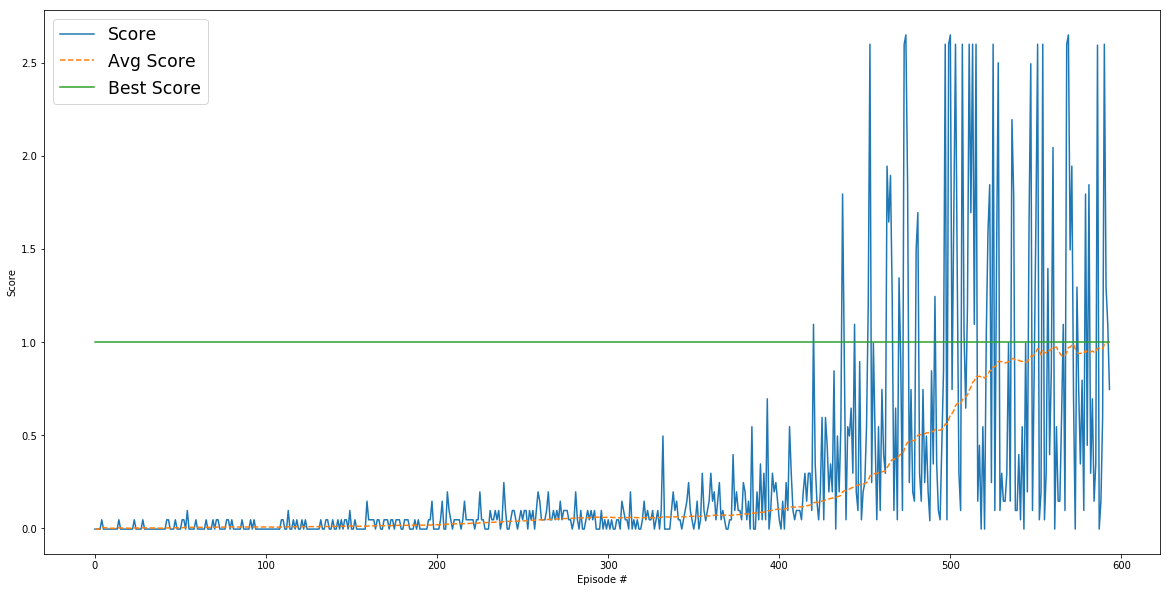

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores, linestyle='--')
plt.plot(np.arange(len(scores)), np.ones(len(scores)) * best_avg_score, linestyle='-')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(('Score', 'Avg Score', 'Best Score'), fontsize='xx-large')
plt.show()

# Model Performance
The agents at  at the initial stage ware not able to accumulate much rewards either could not collaborate, however with more exploration and learning the model performance improved to an average score of +1 their by solving the environment. the reward continued to increase gradually until an optimal value was achived.



When finished, you can close the environment.

In [14]:
env.close()